In [1]:
# pip install git+https://github.com/AltamarMx/iertools.git


# Referencias
Duffie, J. A., & Beckman, W. A. (2013). Solar Engineering of Thermal Processes (4th ed.). Wiley.


In [18]:
import pvlib
import pandas as pd
import math
import numpy as np
from iertools.read import read_epw
from dateutil.parser import parse
import locale
import pytz
from ehtools.diatipico import *
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8')

timezone = pytz.timezone('America/Mexico_City')


In [19]:
# Definir la ubicación y el tiempo
f_epw = '../epw/MEX_MOR_Cuernavaca-Matamoros.Intl.AP.767260_TMYx.2004-2018.epw'
epw = read_epw(f_epw,alias=True,year='2024',warns=False)

lat = 18.8502768
lon = -99.2837051
altitude = 1280
mes = '02'
dia = '15'
absortancia = 0.3
h = 13.

# Parámetros de la superficie
surface_tilt = 90  # Vertical
surface_azimuth = 270  # 

if surface_tilt == 0:
    LWR = 3.9
else:
    LWR = 0.

f1 = f'2024-{mes}-{dia} 00:00'
f2 = f'2024-{mes}-{dia} 23:59'

dia = pd.date_range(start=f1, end=f2, freq='1s',tz=timezone)
location = pvlib.location.Location(latitude = lat, 
                                   longitude=lon, 
                                   altitude=altitude,
                                   tz=timezone,
                                   name='Temixco,Mor')

dia = location.get_solarposition(dia)
del dia['apparent_zenith']
del dia['apparent_elevation']

sunrise,_ = get_sunrise_sunset_times(dia)
tTmax,Tmin,Tmax = calculate_tTmaxTminTmax(mes,epw)

# # Calcular la temperatura ambiente y agregarla al DataFrame
dia = temperature_model(dia, Tmin, Tmax, sunrise, tTmax)
# # Agrega Ig, Ib, Id a dia 

dia = add_IgIbId_Tn(dia,epw,mes,f1,f2,timezone)

total_irradiance = pvlib.irradiance.get_total_irradiance(
    surface_tilt=surface_tilt,
    surface_azimuth=surface_azimuth,
    dni=dia['Ib'],
    ghi=dia['Ig'],
    dhi=dia['Id'],
    solar_zenith=dia['zenith'],
    solar_azimuth=dia['azimuth']
)
dia['Is'] = total_irradiance.poa_global
dia['Tsa'] = dia.Ta + dia.Is*absortancia/h - LWR
DeltaTa= dia.Ta.max() - dia.Ta.min()

dia['DeltaTn'] = calculate_DtaTn(DeltaTa)
print(Tmin,Tmax,sunrise,tTmax)

14.492857142857144 28.142857142857142 7.133333333333334 14.107142857142858


In [20]:

epw_mes = epw.loc[epw.index.month==int(mes)]
hora_minutos = epw_mes.resample('D').To.idxmax()
hora = hora_minutos.dt.hour
minuto = hora_minutos.dt.minute
tTmax = hora.mean() +  minuto.mean()/60 
# epw_mes = epw.loc[epw.index.month==int(mes)]
# horas  = epw_mes.resample('D').To.idxmax().resample('ME').mean().dt.hour 
# minutos = epw_mes.resample('D').To.idxmax().resample('ME').mean().dt.minute
# tTmax = horas.iloc[0]+ minutos.iloc[0]/60 
Tmin =  epw_mes.resample('D').To.min().resample('ME').mean().iloc[0]
Tmax =  epw_mes.resample('D').To.max().resample('ME').mean().iloc[0]

print(tTmax,Tmin,Tmax)

14.107142857142858 14.492857142857144 28.142857142857142


In [21]:
dia.to_parquet("../data/dia.parquet")

In [22]:

def plot_Tsa_Ta(dia):
    
    df = dia.reset_index().iloc[::600]
    fig = px.line(df,x="index",y=["Tsa","Ta"])
    fig.add_trace(go.Scatter(
                            x=df["index"], 
                            y=df['Tn'] + df['DeltaTn'], 
                            mode='lines',
                            showlegend=False , 
                            line=dict(color='rgba(0,0,0,0)')
                            )
    )
    
    fig.add_trace(go.Scatter(
                            x=df["index"], 
                            y=df['Tn'] -df['DeltaTn'], 
                            mode='lines',
                            showlegend=False , 
                            fill='tonexty',
                            line=dict(color='rgba(0,0,0,0)'),
                            fillcolor='rgba(0,255,0,0.3)'
                            )
    )
    
    # Personalizar el layout
    
    fig.update_layout(
        yaxis_title='Temperatura (°C)',
        legend_title='',  # Quitar el título de la leyenda
        xaxis_title=''
    )
    return fig


def plot_I(dia):
    df = dia.reset_index().iloc[::600]
    fig = px.line(df,x="index",y=["Ig","Ib","Id","Is"])

# Personalizar el layout
    fig.update_layout(
        yaxis_title='Temp (oC)',
        legend_title='',  # Quitar el título de la leyenda
        xaxis_title=''
    )
    return fig

In [23]:
epw

,Data Source and Uncertainty Flags,To,Dew Point Temperature,RH,P,Extraterrestrial Horizontal Radiation,Extraterrestrial Direct Normal Radiation,Horizontal Infrared Radiation Intensity,Ig,Ib,...,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snowfall,Albedo,Liquid Precipitation Depth,Liquid Precipitation Quantity
tiempo,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9*9?9?9?9,19.3,10.8,58,87415,0,0,339,0,0,...,77777,9,999999999,25,0.085,0,88,0.132,0.0,0.0
2024-01-01 01:00:00,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9*9?9?9?9,18.6,10.6,59,87602,0,0,335,0,0,...,77777,9,999999999,25,0.085,0,88,0.132,0.0,0.0
2024-01-01 02:00:00,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9*9?9?9?9,17.9,10.3,61,87788,0,0,332,0,0,...,77777,9,999999999,24,0.085,0,88,0.132,0.0,0.0
2024-01-01 03:00:00,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9*9?9?9?9,17.3,10.8,66,87554,0,0,330,0,0,...,77777,9,999999999,26,0.085,0,88,0.132,0.0,0.0
2024-01-01 04:00:00,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9*9?9?9?9,16.6,11.3,71,87321,0,0,327,0,0,...,77777,9,999999999,27,0.085,0,88,0.132,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9*9?9?9?9,20.7,6.3,39,87041,0,0,382,0,0,...,77777,9,999999999,16,0.085,0,88,0.157,0.0,0.0
2024-12-31 20:00:00,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9*9?9?9?9,19.8,6.3,41,86975,0,0,377,0,0,...,77777,9,999999999,16,0.085,0,88,0.157,0.0,0.0
2024-12-31 21:00:00,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9*9?9?9?9,16.0,4.5,46,86861,0,0,356,0,0,...,77777,9,999999999,14,0.085,0,88,0.157,0.0,0.0


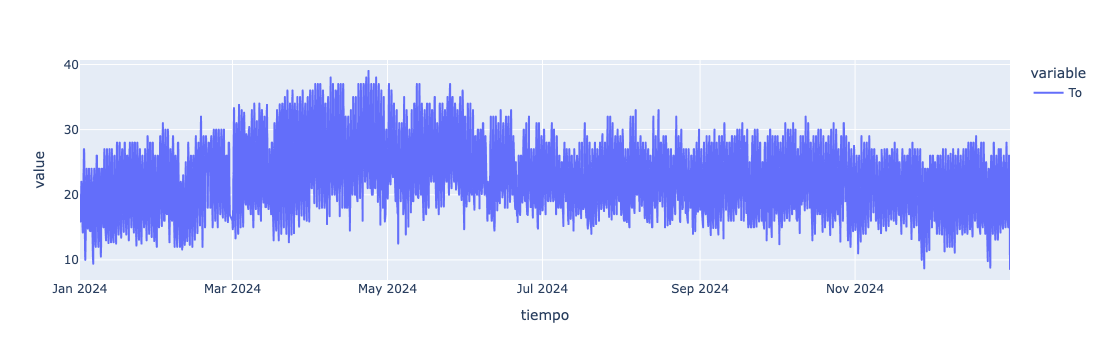

In [24]:
df = epw.reset_index()
fig = px.line(df,x="tiempo",y=["To"])
fig.show()

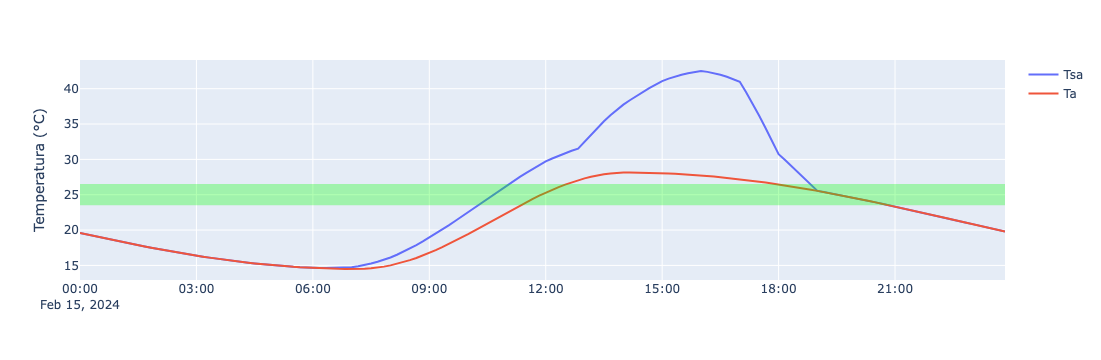

In [25]:
plot_Tsa_Ta(dia)

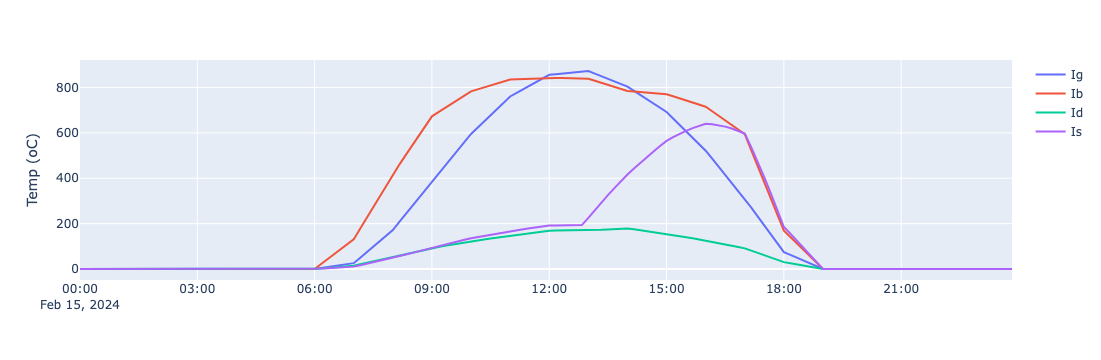

In [26]:
plot_I(dia)

In [27]:
dia

,zenith,elevation,azimuth,equation_of_time,Ta,Ig,Ib,Id,Tn,Is,Tsa,DeltaTn
2024-02-15 00:00:00-06:00,166.292835,-76.292835,294.129023,-14.123533,19.599009,0.0,0.0,0.0,25.012273,0.0,19.599009,1.5
2024-02-15 00:00:01-06:00,166.296431,-76.296431,294.136995,-14.123532,19.598670,0.0,0.0,0.0,25.012273,0.0,19.598670,1.5
2024-02-15 00:00:02-06:00,166.300028,-76.300028,294.144970,-14.123532,19.598332,0.0,0.0,0.0,25.012273,0.0,19.598332,1.5
2024-02-15 00:00:03-06:00,166.303624,-76.303624,294.152950,-14.123531,19.597993,0.0,0.0,0.0,25.012273,0.0,19.597993,1.5
2024-02-15 00:00:04-06:00,166.307220,-76.307220,294.160933,-14.123531,19.597655,0.0,0.0,0.0,25.012273,0.0,19.597655,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-15 23:58:56-06:00,165.911970,-75.911970,294.904119,-14.076002,19.620684,0.0,0.0,0.0,25.012273,0.0,19.620684,1.5
2024-02-15 23:58:57-06:00,165.915545,-75.915545,294.912098,-14.076002,19.620345,0.0,0.0,0.0,25.012273,0.0,19.620345,1.5
2024-02-15 23:58:58-06:00,165.919119,-75.919119,294.920081,-14.076001,19.620007,0.0,0.0,0.0,25.012273,0.0,19.620007,1.5
2024-02-15 23:58:59-06:00,165.922693,-75.922693,294.928067,-14.076001,19.619668,0.0,0.0,0.0,25.012273,0.0,19.619668,1.5


<Axes: >

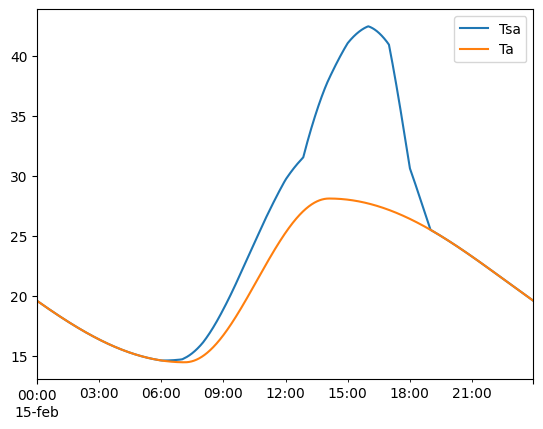

In [29]:
dia[['Tsa','Ta']].plot()